In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   ferrara
   2   rimini
   3   ravenna
   4   trieste
   5   vibo_valentia
   6   caltanissetta
   7   pavia
   8   bolzano
   9   venezia
   10   ascoli_piceno
   11   vicenza
   12   cagliari
   13   napoli
   14   treviso
   15   trapani
   16   nuoro
   17   belluno
   18   parma
   19   reggio_nell_emilia
   20   cremona
   21   bologna
   22   verona
   23   verbania
   24   latina
   25   massa
   26   teramo
   27   benevento
   28   biella
   29   grosseto
   30   novara
   31   imperia
   32   piacenza
   33   carbonia
   34   fermo
   35   cuneo
   36   pisa
   37   foggia
   38   forli
   39   catania
   40   chieti
   41   asti
   42   ragusa
   43   matera
   44   enna
   45   lodi
   46   taranto
   47   rieti
   48   cosenza
   49   varese
   50   brindisi
   51   bat
   52   potenza
   53   genova
   54   lecce
   55   l_aquila
   56   padova
   57   trento
   58   como
   59   milano
   60 

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 ferrara
2 rimini
3 ravenna
4 trieste
5 vibo_valentia
6 caltanissetta
7 pavia
8 bolzano
9 venezia
10 ascoli_piceno
11 vicenza
12 cagliari
13 napoli
14 treviso
15 trapani
16 nuoro
17 belluno
18 parma
19 reggio_nell_emilia
20 cremona
21 bologna
22 verona
23 verbania
24 latina
25 massa
26 teramo
27 benevento
28 biella
29 grosseto
30 novara
31 imperia
32 piacenza
33 fermo
34 cuneo
35 pisa
36 foggia
37 forli
38 catania
39 chieti
40 asti
41 ragusa
42 matera
43 enna
44 lodi
45 taranto
46 rieti
47 cosenza
48 varese
49 brindisi
50 bat
51 potenza
52 genova
53 lecce
54 l_aquila
55 padova
56 trento
57 como
58 milano
59 crotone
60 monza
61 vercelli
62 savona
63 gorizia
64 lucca
65 oristano
66 sondrio
67 arezzo
68 bari
69 pordenone
70 firenze
71 pescara
72 avellino
73 salerno
74 udine
75 terni
76 ancona
77 roma
78 campobasso
79 palermo
80 brescia
81 torino
82 viterbo
83 bergamo
84 prato
85 pistoia
86 lecco
87 siracusa
88 modena
89 alessandria
90 macerata
91 frosinone
92 sassari
93 mantova
94 livorn

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

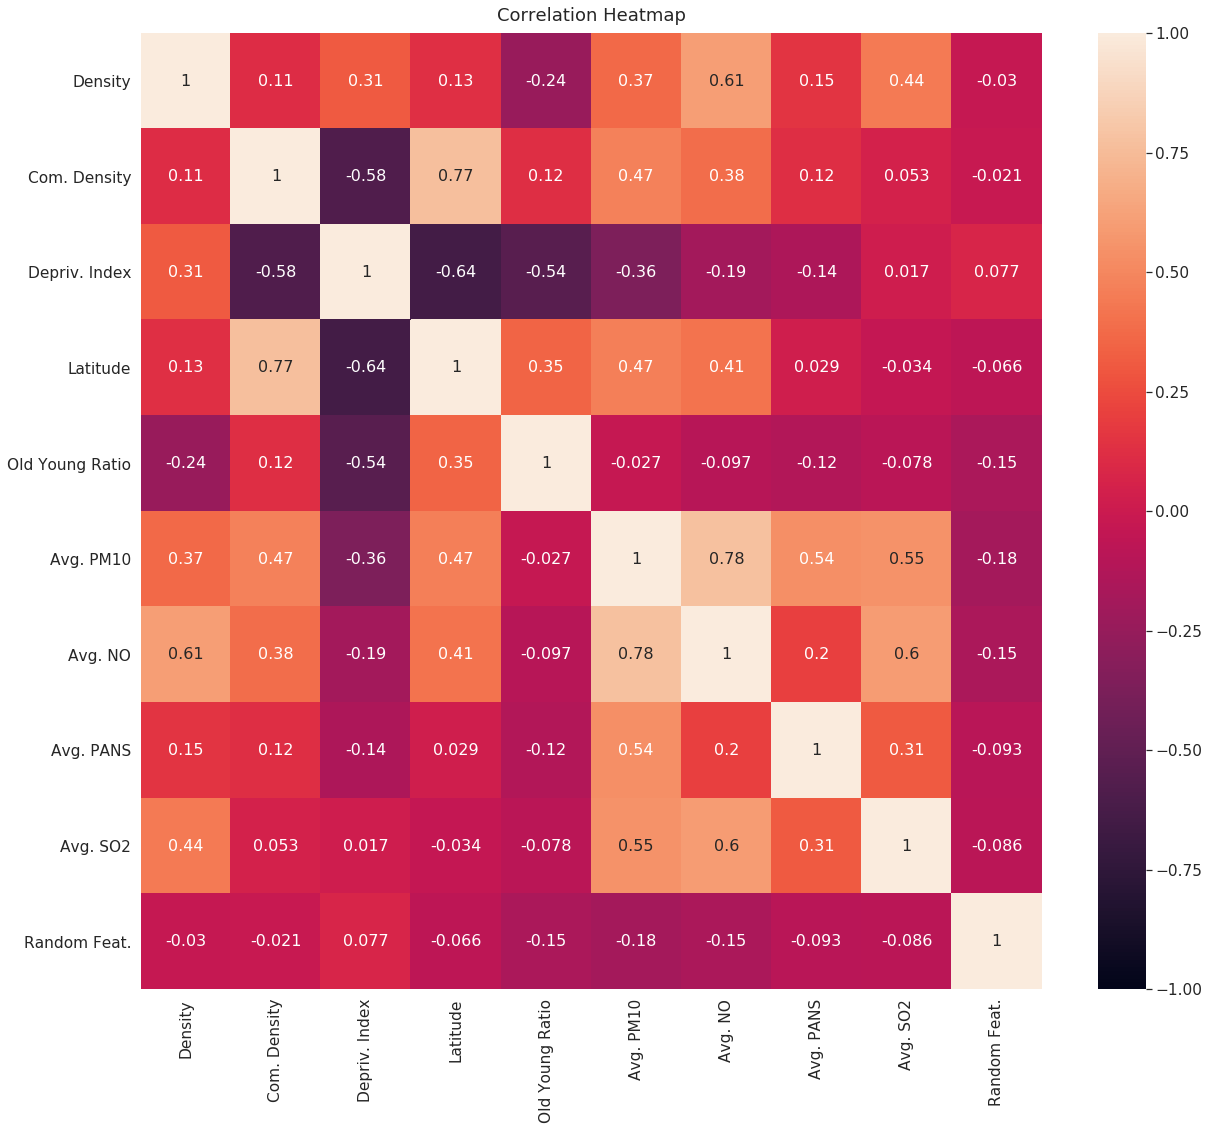

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

In [ ]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

In [ ]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opttest_set", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)